# Problem Tanımı

Problem Tanımı: Omurga Disk Kayması Tespiti

Omurga disk kayması, omurgadaki disklerin yer değiştirmesi sonucu omurilik veya sinirlere baskı yaparak ağrı ve fonksiyon kaybına yol açan bir durumdur. Günümüzde, manyetik rezonans görüntüleme (MRI) gibi ileri görüntüleme teknikleri kullanılarak disk kayması tespiti yapılmaktadır. Ancak, bu tür görüntülerin incelenmesi oldukça zaman alıcıdır ve hata payı insan faktörüne bağlı olarak değişebilmektedir. Bu projede, MRI görüntüleri üzerinde otomatik segmentasyon teknikleri kullanılarak omurga disk kayması ve hasar tespiti yapmayı hedefliyoruz.

Bu projenin amacı, disk kaymasının hızlı ve doğru bir şekilde tespitini sağlayacak bir otomasyon sistemi geliştirmektir. Bu sistem, omurga bölgesindeki kaymış diskleri segmentasyon yoluyla işaretleyecek ve ardından potansiyel hastalıklı alanları tanımlayacaktır.

# Çözüm Aşamaları


1. Veri Hazırlığı ve Ön İşleme
2. İlk Aşama: Ana Beden Segmentasyonu (Omurga ve Disklerin Tespiti)
3. İkinci Aşama: İnce Detayların Segmentasyonu (Disk Kayması Tespiti)
4. Model Eğitimi ve İyileştirme
5. Sonuçların Görselleştirilmesi
6. Sonuçların Değerlendirilmesi ve İyileştirilmesi
7. Uygulama ve Klinik Kullanım:

# İlk 3 Görsel Çıktısı

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def goruntuleri_goster(db_path):

    # img ve label dosyalarını bul
    img_files = sorted([f for f in os.listdir(db_path) if f.startswith('img') and f.endswith('.png')])
    label_files = sorted([f for f in os.listdir(db_path) if f.startswith('label') and f.endswith('.png')])

    # İlk 3 görüntüyü seç
    img_files = img_files[:3]
    label_files = label_files[:3]

    # Görüntüleri ve etiketleri göster
    plt.figure(figsize=(12, 8))

    for i in range(3):
        # img görüntüsünü yükle
        img_path = os.path.join(db_path, img_files[i])
        img = Image.open(img_path).convert("L")

        # label görüntüsünü yükle
        label_path = os.path.join(db_path, label_files[i])
        label = Image.open(label_path).convert("L")

        # Görüntüleri yan yana göster
        plt.subplot(3, 2, 2 * i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')  # Eksenleri kapat
        plt.title(f'Image {i + 1}')

        plt.subplot(3, 2, 2 * i + 2)
        plt.imshow(label, cmap='gray')
        plt.axis('off')  # Eksenleri kapat
        plt.title(f'Label {i + 1}')

    plt.tight_layout()
    plt.show()

# Fonksiyonu çağırın
goruntuleri_goster(r"C:\Users\mtdev\OneDrive\Masaüstü\34\db")


IndexError: list index out of range

<Figure size 864x576 with 0 Axes>

In [23]:
from monai.transforms import ScaleIntensity
import torch
from PIL import Image
import numpy as np

# Görüntü dosyasının yolu
image_path = r"C:\Users\mtdev\OneDrive\Masaüstü\34\DB\img (1).png"

# Görüntüyü yükleme
image = Image.open(image_path).convert("L")  # "L" ile gri tonlamaya çeviriyoruz
image_array = np.array(image)

# Normalize etmek için ScaleIntensity kullanıyoruz
# Görüntü değerleri 0-255 aralığından 0-1 aralığına dönüştürülür.
normalize_transform = ScaleIntensity(minv=0.0, maxv=255.0)

# Normalizasyon işlemi
normalized_image = normalize_transform(image_array)

# Sonuçları kontrol et
normalized_image_pil = Image.fromarray((normalized_image * 255).astype(np.uint8))
normalized_image_pil.show()  # Normalized image'ı görüntüle


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from monai.transforms import Compose, LoadImage, ScaleIntensity
from monai.data import DataLoader, ArrayDataset
from monai.metrics import DiceMetric
from monai.losses import DiceLoss

# Model ve cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# UNet modelini tanımla
model = UNet(
    spatial_dims=2,  # 2D model
    in_channels=1,  # 1 kanal (grayscale)
    out_channels=1,  # 1 çıktı (binary segmentation)
    channels=(16, 32, 64, 128, 256),  # Kanal büyüklükleri
    strides=(2, 2, 2, 2),  # Stride değerleri
    kernel_size=3,  # Filtre boyutu
    up_kernel_size=3,  # Yükseltme kernel boyutu
    act=("relu",)  # Aktivasyon fonksiyonu
).to(device)

# Loss fonksiyonu ve optimizer
loss_function = DiceLoss(sigmoid=True)  # Sigmoid ile birlikte Dice kaybı
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Eğitim verisi ve dönüşümler
train_transforms = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])
train_ds = ArrayDataset(images, train_transforms, labels, train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

# Test verisi ve dönüşümler
test_transforms = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])
test_ds = ArrayDataset(test_images, test_transforms, test_labels, test_transforms)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

# Dice metrikleri
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)

# Eğitim döngüsü
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_data in train_loader:
        images, labels = batch_data

        # Görüntüler ve etiketleri device'a taşı
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Modelin çıktısını al
        outputs = model(images)

        # Kaybı hesapla
        loss = loss_function(outputs, labels)
        loss.backward()

        # Optimizer adımını at
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Modeli kaydet
torch.save(model.state_dict(), "model.pth")

# Test verisi ile doğruluk hesaplama
model.eval()
with torch.no_grad():
    for batch_data in test_loader:
        images, labels = batch_data

        # Görüntü ve etiketleri device'a taşı
        images = images.to(device)
        labels = labels.to(device)

        # Modelin tahminini al
        outputs = model(images)

        # Dice metriğini hesapla
        dice_metric(outputs, labels)

# Dice metriğini yazdır
mean_dice = dice_metric.aggregate().item()
print(f'Mean Dice Score on Test Set: {mean_dice:.4f}')


ModuleNotFoundError: No module named 'torchvision'

## Kütüphaneleri import et

# Scale norm

In [2]:
from monai.transforms import ScaleIntensityRange
import numpy as np
from PIL import Image

# Görüntü dosya yolunu doğru şekilde belirtin
image_path = r"C:\Users\mtdev\OneDrive\Masaüstü\34\DB\img (1).png"

# ScaleNorm işlemini tanımla
scale_transform = ScaleIntensityRange(a_min=0, a_max=255, b_min=0, b_max=1)

# Görüntüyü yükleme ve numpy array formatına dönüştürme
image = Image.open(image_path).convert("L")  # "L" ile gri tonlamaya çeviriyoruz
image_array = np.array(image)

# ScaleNorm işlemini uygula
scaled_image = scale_transform(image_array)

# Sonuç görüntüyü kontrol et
scaled_image_pil = Image.fromarray((scaled_image * 255).astype(np.uint8))  # Yeniden 0-255 aralığına dönüştür
scaled_image_pil.show()  # Görüntüyü ekranda göster
scaled_image_pil.save("scaled_image.png")  # Görüntüyü kaydet (isteğe bağlı)


# JSON TO PNG

In [2]:
import json
import numpy as np
from PIL import Image
import os
import cv2

# JSON dosya yolunu belirtin
json_dir = r"C:\Users\mtdev\OneDrive\Masaüstü\34\jsonlar"
output_dir = "labels"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# JSON dosyalarının listesini al
json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

for json_file in json_files:
    # JSON dosyasını aç
    with open(os.path.join(json_dir, json_file)) as f:
        data = json.load(f)

    # Görsel boyutunu ve işaretli poligonları al
    img_height = data['imageHeight']
    img_width = data['imageWidth']
    polygons = [shape['points'] for shape in data['shapes']]

    # Boş bir maske oluştur
    mask = np.zeros((img_height, img_width), dtype=np.uint8)

    # Poligonları maske üzerine çiz
    for polygon in polygons:
        polygon = np.array(polygon, np.int32)
        cv2.fillPoly(mask, [polygon], 255)

    # PNG dosyası olarak kaydet
    png_filename = os.path.splitext(json_file)[0] + '.png'
    Image.fromarray(mask).save(os.path.join(output_dir, png_filename))

print("Tüm JSON dosyaları PNG'ye dönüştürüldü.")


Tüm JSON dosyaları PNG'ye dönüştürüldü.


## Klasördeki görüntü ve maskeleri tek değişkene bağla

In [ ]:
import os
from glob import glob

# Dosya yollarını belirtin
image_dir = r"C:\Users\mtdev\OneDrive\Masaüstü\34\DB"
label_dir = r"C:\Users\mtdev\OneDrive\Masaüstü\34\DB"

# Görüntüleri ve etiketleri yüklüyoruz
images = sorted(glob(os.path.join(image_dir, "img*.png")))
labels = sorted(glob(os.path.join(label_dir, "label*.png")))

print(images)
print(labels)


['C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (1).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (10).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (2).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (3).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (4).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (5).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (6).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (7).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (8).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\img (9).png']
['C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\label (1).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\label (10).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\label (2).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\label (3).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\label (4).png', 'C:\\Users\\mtdev\\OneDrive\\Masaüstü\\34\\DB\\label (5).png', 'C:\\Use

## Compose: Görüntü üzerinde yapılacak dönüşümleri birleştir

In [10]:
import os
from glob import glob
from monai.transforms import Compose, LoadImage, ScaleIntensity, RandSpatialCrop, RandRotate90, RandFlip, RandZoom, RandGaussianNoise, Activations, AsDiscrete
from torch.utils.data import DataLoader
from monai.data import ArrayDataset
import torch
# Dosya yollarını belirtin
image_dir = r"C:\Users\mtdev\OneDrive\Masaüstü\34\DB"
label_dir = r"C:\Users\mtdev\OneDrive\Masaüstü\34\DB"

# Görüntüleri ve etiketleri yükleme
images = sorted(glob(os.path.join(image_dir, "img*.png")))
labels = sorted(glob(os.path.join(label_dir, "label*.png")))

# Eğitim ve test verilerini bölme (8 eğitim, 2 test)
train_images = images[:8]
train_labels = labels[:8]
test_images = images[8:]
test_labels = labels[8:]

# Eğitim verisi dönüşümü
train_imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        RandSpatialCrop((256, 256), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        RandFlip(prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.55),
        RandGaussianNoise(prob=0.5)
    ]
)

train_labeltrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        RandSpatialCrop((256, 256), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    ]
)

# Test verisi dönüşümü
test_imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
    ]
)

test_labeltrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

# Post-processing işlemi
post_trans = Compose(
    [
        Activations(sigmoid=True),
        AsDiscrete(threshold=0.6),
    ]
)

# Dataset ve DataLoader ayarları
train_ds = ArrayDataset(train_images, train_imtrans, train_labels, train_labeltrans)
test_ds = ArrayDataset(test_images, test_imtrans, test_labels, test_labeltrans)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(
    test_ds,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

print(f"Eğitim seti: {len(train_images)} görsel")
print(f"Test seti: {len(test_images)} görsel")

Eğitim seti: 8 görsel
Test seti: 2 görsel


## Klasördeki görüntülerin okunması ve dönüştürülmesi nesnesi:

In [11]:
ds = ArrayDataset(images, train_imtrans, labels, train_labeltrans)


## Yüklenen veri nesnesi

In [34]:
loader = DataLoader(ds, batch_size=16, num_workers=2, pin_memory=torch.cuda.is_available())


## İlk görseller

In [13]:
import matplotlib.pyplot as plt

def goster(goruntuler, titles=None):
    n = len(goruntuler)  # Görüntü sayısını belirle

    # Tek bir görüntü varsa subplot yapısına gerek yok
    if n == 1:
        plt.imshow(goruntuler[0], cmap='gray')
        if titles:  # Eğer başlık verilmişse
            plt.title(titles[0])
        plt.axis('off')
        plt.show()
        return

    # Çoklu görüntüler için subplot yapısı
    fig, axs = plt.subplots(1, n, figsize=(3*n, 3))  # Görüntü sayısına göre boyut

    # Tek boyutlu aks durumunu düzeltmek için (n=1 durumunda tek aks olur)
    if n == 1:
        axs = [axs]

    for i, goruntu in enumerate(goruntuler):
        axs[i].imshow(goruntu, cmap='gray')  # Görüntüyü çiz
        axs[i].axis('off')  # Eksenleri gizle
        if titles:  # Eğer başlık verilmişse
            axs[i].set_title(titles[i])

    plt.subplots_adjust(wspace=0.1)  # Görüntüler arasındaki boşluk
    plt.show()

torch.Size([10, 4, 256, 256]) torch.Size([10, 1, 256, 256])


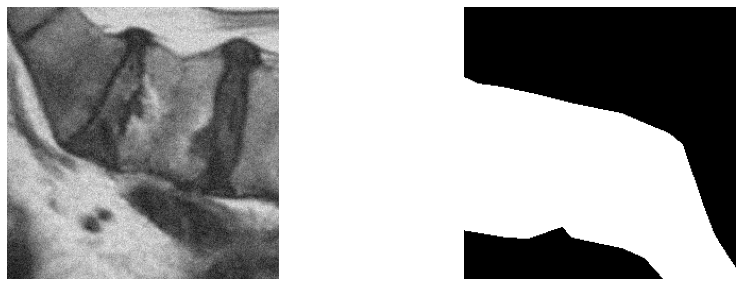

In [15]:
import torch
import matplotlib.pyplot as plt
from monai.utils.misc import first

# Gerekli kütüphaneler
# MONAI, Torch ve Matplotlib'i kullanarak görselleştirme ve veri işleme.

def goster(images):
    """
    Görselleri yan yana gösteren bir fonksiyon.
    images: Görseller listesi (her biri numpy array olmalı)
    """
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    
    if len(images) == 1:  # Eğer sadece bir görsel varsa
        axes = [axes]

    for i, img in enumerate(images):
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')  # Eksenleri gizle
    
    plt.show()

# Veriden ilk örneği al
im, label = first(loader)
print(im.shape, label.shape)

# Eğer tek kanallıysa (örneğin, grayscale)
goster([im[0, 0], label[0, 0]])

# Eğer çok kanallıysa (örneğin, RGB)
# goster([im[0], label[0]])


## Eğitim için ilk 100, test için son 100

In [16]:
train_imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),  # Görüntü yoğunluğunu normalize et
        RandSpatialCrop((256, 256), random_size=False),  # Sabit boyut: 256x256
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),  # %50 olasılıkla 90 derece döndür
    ]
)

train_labeltrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        RandSpatialCrop((256, 256), random_size=False),  # Sabit boyut: 256x256
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),  # %50 olasılıkla 90 derece döndür
    ]
)

# Test verisi dönüşümü
test_imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),  # Test verileri için yalnızca normalize işlemi
    ]
)

# Test etiket verisi dönüşümü
test_labeltrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

# Post-processing işlemi
post_trans = Compose(
    [
        Activations(sigmoid=True),  # Çıkışta sigmoid aktivasyon fonksiyonu
        AsDiscrete(threshold=0.5),  # 0.5 eşiği ile ikili sınıflandırma (0 veya 1 olarak ayrılır)
    ]
)

# Dataset ve DataLoader ayarları
train_ds = ArrayDataset(images[:150], train_imtrans, labels[:150], train_labeltrans)
test_ds = ArrayDataset(images[-28:], test_imtrans, labels[-28:], test_labeltrans)

train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)



##  Benzerlik ölçümü için metrik tanımı

In [36]:
# Modelin doğruluk metriği
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = monai.networks.nets.UNet(
    spatial_dims=2,  # 2D segmentasyon
    in_channels=3,  # RGB görüntüler için 3 kanal
    out_channels=1,  # İkili segmentasyon için 1 kanal
    channels=(32, 64, 128, 256, 512),  # Filtre sayıları
    strides=(2, 2, 2, 2),  # Downsampling işlemi
    num_res_units=2,  # Residual units sayısı
).to(device)

# Kayıp fonksiyonu: Dice Loss (sigmoid ile), eğer çok sınıflı segmentasyon yapıyorsan softmax=True kullanrom monai.losses import DiceCELoss
loss_function = monai.losses.DiceLoss(sigmoid=True)




# AdamW optimizer: Adam optimizer + weight decay (overfitting'i engeller)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)




# Öğrenme oranı azaltma (scheduler): StepLR yerine daha uzun step_size veya ReduceLROnPlateau kullanabilirsin

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)



# Alternatif olarak, ReduceLROnPlateau kullanabilirsin:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

In [38]:
from monai.transforms import (
    LoadImage, ScaleIntensity, RandSpatialCrop, RandRotate90,
    RandFlip, RandZoom, RandGaussianNoise, Compose, EnsureChannelFirst
)

# Eğitim veri dönüşümü
train_imtrans = Compose([
    LoadImage(image_only=True, ensure_channel_first=True),
    ScaleIntensity(),
    RandSpatialCrop((256, 256), random_size=False),
    RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    RandFlip(prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.55),
    RandGaussianNoise(prob=0.5),
    EnsureChannelFirst()  # Kanalın her zaman en başta olduğundan emin ol
])

train_labeltrans = Compose([
    LoadImage(image_only=True, ensure_channel_first=True),
    RandSpatialCrop((256, 256), random_size=False),
    RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    EnsureChannelFirst()  # Kanalın her zaman en başta olduğundan emin ol
])

# Test veri dönüşümleri (değişiklik yapmaya gerek yok)
test_imtrans = Compose([
    LoadImage(image_only=True, ensure_channel_first=True),
    ScaleIntensity(),
])

test_labeltrans = Compose([
    LoadImage(image_only=True, ensure_channel_first=True),
])

# Eğitim döngüsünde kanal kontrolü
for epoch in range(20):
    print(f"Epoch {epoch+1}/20")
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        
        # Kanal sayısı kontrolü
        if inputs.shape[1] > 3:
            inputs = inputs[:, :3, :, :]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # Loss ve accuracy hesapla
        epoch_loss += loss.item()
        acc = calculate_accuracy(outputs, labels)
        epoch_acc += acc.item()

        # TensorBoard'a loss ve accuracy yazdır
        writer.add_scalar("train_loss", loss.item(), epoch * len(train_loader) + step)
        writer.add_scalar("train_accuracy", acc.item(), epoch * len(train_loader) + step)

    # Epoch başına ortalama loss ve accuracy hesapla
    epoch_loss /= step
    epoch_acc /= step
    epoch_loss_values.append(epoch_loss)
    epoch_acc_values.append(epoch_acc)
    print(f"Epoch {epoch+1} average loss: {epoch_loss:.4f}, average accuracy: {epoch_acc:.4f}")

    # Öğrenme oranını güncelle (scheduler)
    scheduler.step()

    # Early stopping kontrolü
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# TensorBoard'u kapatma
writer.close()


Epoch 1/20


AttributeError: 'tuple' object has no attribute 'to'

In [43]:
torch.save(model.state_dict(), "model.pth")

In [39]:
img = 0
roi_size = (256, 256)  # Sliding window için daha büyük bir boyut seçilebilir
sw_batch_size = 4  # Belleğe göre optimize edilebilir
max_images_to_show = 3  # Görselleştirmek istediğin maksimum görüntü sayısını değiştir

# Model tahminleri ve post işleme için işlemler
model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)

        # Sliding window inference (model tahminlerini al)
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)

        # Post-processing işlemi
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

        # Görselleştirme için ilk 3 görüntüyü seç
        for i in range(min(max_images_to_show, len(test_images))):
            goster([
                test_images[i][0].cpu().detach().numpy(),  # Orijinal test görüntüsü
                test_labels[i][0].cpu().detach().numpy(),  # Etiket
                test_outputs[i][0].cpu().detach().numpy()  # Model çıktısı
            ], titles=["Görüntü", "Gerçek Etiket", "Tahmin"])

        img += 1
        if img == max_images_to_show:
            break


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\monai\data\utils.py", line 519, in list_data_collate
    ret = collate_fn(data)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 211, in collate
    return [
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\monai\data\utils.py", line 456, in collate_meta_tensor_fn
    collated = collate_tensor_fn(batch)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\monai\data\meta_tensor.py", line 282, in __torch_function__
    ret = super().__torch_function__(func, types, args, kwargs)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py", line 1512, in __torch_function__
    ret = func(*args, **kwargs)
RuntimeError: stack expects each tensor to be equal size, but got [4, 523, 856] at entry 0 and [4, 849, 855] at entry 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\monai\data\utils.py", line 532, in list_data_collate
    raise RuntimeError(re_str) from re
RuntimeError: stack expects each tensor to be equal size, but got [4, 523, 856] at entry 0 and [4, 849, 855] at entry 1

MONAI hint: if your transforms intentionally create images of different shapes, creating your `DataLoader` with `collate_fn=pad_list_data_collate` might solve this problem (check its documentation).


# En iyi ve En kötü Tahmin

In [40]:
from monai.data import decollate_batch
print("decollate_batch başarıyla import edildi.")


decollate_batch başarıyla import edildi.


In [41]:
import torch
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, Activations, AsDiscrete
from monai.metrics import DiceMetric

# Post-processing işlemi için 'post_trans' oluşturuluyor
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# En iyi ve en kötü Dice skorlarını belirlemek için değişkenler
best_score = float('-inf')  # En iyi skoru en düşükten başlat
worst_score = float('inf')  # En kötü skoru en yüksekte başlat
best_image, worst_image = None, None
best_label, worst_label = None, None
best_pred, worst_pred = None, None

model.eval()
dice_metric = DiceMetric(include_background=False, reduction="mean")

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)

        # Etiketleri 0-1 aralığına dönüştür
        test_labels = test_labels / 255.0

        preds = sliding_window_inference(test_images, roi_size=(256, 256), sw_batch_size=4, predictor=model)
        preds = [post_trans(i) for i in preds]

        # Her örnek için Dice skorunu hesapla
        for i in range(len(test_images)):
            dice_metric(y_pred=preds[i].unsqueeze(0), y=test_labels[i].unsqueeze(0))
            dice_score = dice_metric.aggregate().item()
            dice_metric.reset()

            # Debugging: Dice skoru ve şekil bilgilerini yazdır
            print(f"Örnek {i} Dice Skoru: {dice_score}")
            print(f"Tahmin Şekli: {preds[i].shape}, Etiket Şekli: {test_labels[i].shape}")
            print(f"Tahmin Benzersiz Değerler: {torch.unique(preds[i])}, Etiket Benzersiz Değerler: {torch.unique(test_labels[i])}")

            # En iyi ve en kötü tahminleri belirle
            if dice_score > best_score:
                best_score = dice_score
                best_image = test_images[i].cpu().numpy()[0]  # Numpy'ye dönüştür ve 2D dilimi al
                best_label = test_labels[i].cpu().numpy()[0]  # Numpy'ye dönüştür ve 2D dilimi al
                best_pred = preds[i].cpu().numpy()[0]  # Numpy'ye dönüştür ve 2D dilimi al

            if dice_score < worst_score:
                worst_score = dice_score
                worst_image = test_images[i].cpu().numpy()[0]  # Numpy'ye dönüştür ve 2D dilimi al
                worst_label = test_labels[i].cpu().numpy()[0]  # Numpy'ye dönüştür ve 2D dilimi al
                worst_pred = preds[i].cpu().numpy()[0]  # Numpy'ye dönüştür ve 2D dilimi al

# Debugging: Kontrol et, None olup olmadıklarını
if best_image is None or best_label is None or best_pred is None:
    print("En iyi örnekler None olarak kaldı!")
if worst_image is None or worst_label is None or worst_pred is None:
    print("En kötü örnekler None olarak kaldı!")

# Görselleştirme fonksiyonu
def goster(goruntuler, titles=None):
    n = len(goruntuler)
    fig, axs = plt.subplots(1, n, figsize=(3 * n, 3))
    if n == 1:
        axs = [axs]

    for i, goruntu in enumerate(goruntuler):
        if goruntu is not None:
            # Görüntü verisini 2D boyuta dönüştür (squeeze() ile)
            axs[i].imshow(goruntu.squeeze(), cmap='gray')  # squeeze() ile fazla boyutları at
            axs[i].axis('off')
            if titles:
                axs[i].set_title(titles[i])
        else:
            axs[i].axis('off')
            if titles:
                axs[i].set_title(f"None - {titles[i]}")

    plt.subplots_adjust(wspace=0.1)
    plt.show()

print("En iyi test örneği:")
goster([best_image, best_label, best_pred], titles=["Görüntü", "Gerçek Etiket", "Tahmin"])

print("En kötü test örneği:")
goster([worst_image, worst_label, worst_pred], titles=["Görüntü", "Gerçek Etiket", "Tahmin"])


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\monai\data\utils.py", line 519, in list_data_collate
    ret = collate_fn(data)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 211, in collate
    return [
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\monai\data\utils.py", line 456, in collate_meta_tensor_fn
    collated = collate_tensor_fn(batch)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\monai\data\meta_tensor.py", line 282, in __torch_function__
    ret = super().__torch_function__(func, types, args, kwargs)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py", line 1512, in __torch_function__
    ret = func(*args, **kwargs)
RuntimeError: stack expects each tensor to be equal size, but got [4, 523, 856] at entry 0 and [4, 849, 855] at entry 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "C:\Users\mtdev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\monai\data\utils.py", line 532, in list_data_collate
    raise RuntimeError(re_str) from re
RuntimeError: stack expects each tensor to be equal size, but got [4, 523, 856] at entry 0 and [4, 849, 855] at entry 1

MONAI hint: if your transforms intentionally create images of different shapes, creating your `DataLoader` with `collate_fn=pad_list_data_collate` might solve this problem (check its documentation).
